In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import tensorflow as tf

from tensorflow import keras
import random
import numpy as np
from numpy import ndarray
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import pickle

from tensorflow.keras.layers import (Input, Dropout, LSTM, Reshape, LeakyReLU,
                          Concatenate, ReLU, Flatten, Dense, Embedding,
                          BatchNormalization, Activation, SpatialDropout1D,
                          Conv2D, MaxPooling2D, Softmax, 
                           Lambda)
#from tensorflow.keras.layers.experimental.preprocessing import CategoryEncoding
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam, RMSprop
import tensorflow.keras.backend as K
from tensorflow.keras.activations import tanh

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#import np_utils
from tensorflow.keras.utils import to_categorical
from IPython.display import clear_output
import matplotlib.pyplot as plt
import csv
from progressbar import ProgressBar
import seaborn as sns
from tensorflow import random as randomtf
from tensorflow.keras.backend import argmax as argmax

from tensorflow import one_hot
from rdkit import rdBase
rdBase.DisableLog('rdApp.error')
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from rdkit import Chem
from sklearn.metrics import r2_score

randomtf.set_seed(1)
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
random.seed(12345)
import matplotlib as mpl
from matplotlib import rc, rcParams

2023-06-13 14:15:17.664461: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-13 14:15:17.730269: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-13 14:15:18.060344: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda-11.2/lib64:
2023-06-13 14:15:18.060384: W tensorflow/compile

In [2]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.3)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1, gpu_options=gpu_options)
tf.compat.v1.set_random_seed(1234)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

2023-06-13 14:15:18.766738: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-13 14:15:18.776353: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-13 14:15:18.781055: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-13 14:15:18.781163: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at

2023-06-13 14:15:19.096402: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-13 14:15:19.096540: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-13 14:15:19.096602: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-13 14:15:19.096653: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7272 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


Text(0.5, 0, '!!!Ariaaaal')

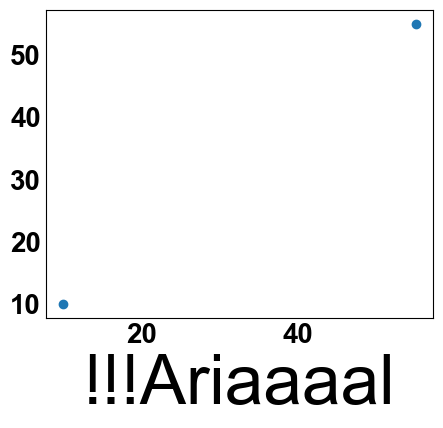

In [3]:
# check the font !!!!!!!!!!!!!!!!!!!!!
# switch to Arial
# if not working: delet ~/.catch/matplotlib
plt.rcParams["font.family"] = "Arial"
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.fonttype'] = 42
mpl.font_manager.FontManager()

rc('font', weight='bold')
fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter([10, 55], [10, 55])
ax.tick_params(axis='both', length=0, width=1.5, colors='black', grid_alpha=0, labelsize=20)
plt.xlabel('!!!Ariaaaal', fontname='Arial', fontsize=50)

In [4]:
tf.compat.v1.keras.backend.clear_session()

In [5]:
with open('./../data/trainingsets/train_regular_pubqc130K/image_train.pickle', 'rb') as f:
    X_smiles_train, SMILES_train, y_train0 = pickle.load(f)

with open('./../data/trainingsets/train_regular_pubqc130K/image_test.pickle', 'rb') as f:
    X_smiles_test, SMILES_test, y_test0 = pickle.load(f)
    
with open('./../data/trainingsets/train_regular_pubqc130K/tokenizer.pickle', 'rb') as f:
    tokenizer = pickle.load(f)
tokenizer[0] = ' '

In [6]:
X_smiles_train0, SMILES_train0, y_train00 = X_smiles_train.copy(), SMILES_train.copy(), y_train0.copy()
X_smiles_test0, SMILES_test0, y_test_real = X_smiles_test.copy(), SMILES_test.copy(), y_test0.copy()

In [7]:
print (X_smiles_train.shape)
print (X_smiles_test.shape)
print (X_smiles_train0.shape)
print (X_smiles_test0.shape)


(106101, 40, 27, 1)
(24819, 40, 27, 1)
(106101, 40, 27, 1)
(24819, 40, 27, 1)


In [8]:
tokenizer

{1: 'C',
 2: 'c',
 3: '(',
 4: ')',
 5: '1',
 6: 'O',
 7: '=',
 8: '.',
 9: 'N',
 10: '2',
 11: '[',
 12: ']',
 13: 'n',
 14: '3',
 15: 'H',
 16: 'S',
 17: '-',
 18: '#',
 19: '+',
 20: 's',
 21: 'o',
 22: 'P',
 23: 'F',
 24: '4',
 25: 'l',
 26: 'p',
 0: ' '}

In [9]:
# normalize the gap value between [0-11]
y_train = (y_train00 - 0) / 11
y_test = (y_test0 - 0) / 11

print ('min norm', min(y_train))
print ('min ', min(y_train00))
print ('max norm', max(y_train))
print ('max ', max(y_train00))

print (min(y_test))
print (min(y_test0))
print (max(y_test))
print (max(y_test0))

min norm 0.09527272727272727
min  1.048
max norm 0.9986363636363635
max  10.985
0.10436363636363635
1.148
0.9779090909090908
10.757


In [10]:
y_train0 = y_train.copy()
y_test0 = y_test.copy()

In [11]:
# Encoding to an image embedding
# ENCODER
inp_1 = Input(shape = [40, 27, 1])

y1 = Conv2D(64, (23, 10), strides = 1, padding = 'valid')(inp_1)
y1 = LeakyReLU(alpha = 0.2)(y1)
y1 = BatchNormalization()(y1)

y1 = Conv2D(64, 3, strides = 1, padding = 'valid')(y1)
y1 = LeakyReLU(alpha = 0.2)(y1)
y1 = BatchNormalization()(y1)

y1 = Conv2D(64, 3, strides = 1, padding = 'valid')(y1)
y1 = LeakyReLU(alpha = 0.2)(y1)
y1 = BatchNormalization()(y1)

y1 = Conv2D(64, 3, strides = 1, padding = 'valid')(y1)
y1 = LeakyReLU(alpha = 0.2)(y1)
y1 = BatchNormalization()(y1)

y1 = Conv2D(64, 3, strides = 1, padding = 'valid')(y1)
y1 = LeakyReLU(alpha = 0.2)(y1)
y1 = BatchNormalization()(y1)

y1 = Conv2D(64, 3, strides = 1, padding = 'valid')(y1)
y1 = LeakyReLU(alpha = 0.2)(y1)
y1 = BatchNormalization()(y1)

y1 = Conv2D(64, 3, strides = 1, padding = 'valid')(y1)
y1 = LeakyReLU(alpha = 0.2)(y1)
y1 = BatchNormalization()(y1)

y1_emb = Conv2D(1, 3, strides = 1, padding = 'same',
            activation = 'tanh')(y1)

y2 = Conv2D(64, (23, 10), strides = 1, padding = 'valid')(inp_1)
y2 = LeakyReLU(alpha = 0.2)(y2)
y2 = BatchNormalization()(y2)

y2 = Conv2D(64, 3, strides = 1, padding = 'valid')(y2)
y2 = LeakyReLU(alpha = 0.2)(y2)
y2 = BatchNormalization()(y2)

y2 = Conv2D(64, 3, strides = 1, padding = 'valid')(y2)
y2 = LeakyReLU(alpha = 0.2)(y2)
y2 = BatchNormalization()(y2)

y2 = Conv2D(64, 3, strides = 1, padding = 'valid')(y2)
y2 = LeakyReLU(alpha = 0.2)(y2)
y2 = BatchNormalization()(y2)

y2 = Conv2D(64, 3, strides = 1, padding = 'valid')(y2)
y2 = LeakyReLU(alpha = 0.2)(y2)
y2 = BatchNormalization()(y2)

y2 = Conv2D(64, 3, strides = 1, padding = 'valid')(y2)
y2 = LeakyReLU(alpha = 0.2)(y2)
y2 = BatchNormalization()(y2)

y2 = Conv2D(64, 3, strides = 1, padding = 'valid')(y2)
y2 = LeakyReLU(alpha = 0.2)(y2)
y2 = BatchNormalization()(y2)

y2_emb = Conv2D(1, 3, strides = 1, padding = 'same',
                activation = 'tanh')(y2)

####
y_out = Concatenate()([y1_emb, y2_emb])

# DECODER
emb_in = Input(shape = [6, 6, 2])

tower0 = Conv2D(32, 1, padding = 'same')(emb_in)
tower1 = Conv2D(64, 1, padding = 'same')(emb_in)
tower1 = Conv2D(64, 3, padding = 'same')(tower1)
tower2 = Conv2D(32, 1, padding = 'same')(emb_in)
tower2 = Conv2D(32, 5, padding = 'same')(tower2)
tower3 = MaxPooling2D(3, 1, padding = 'same')(emb_in)
tower3 = Conv2D(32, 1, padding = 'same')(tower3)
h = Concatenate()([tower0, tower1, tower2, tower3])
h = ReLU()(h)
h = MaxPooling2D(2, 1, padding = 'same')(h)

for i in range(6):
    tower0 = Conv2D(32, 1, padding = 'same')(h)
    tower1 = Conv2D(64, 1, padding = 'same')(h)
    tower1 = Conv2D(64, 3, padding = 'same')(tower1)
    tower2 = Conv2D(32, 1, padding = 'same')(h)
    tower2 = Conv2D(32, 5, padding = 'same')(tower2)
    tower3 = MaxPooling2D(3, 1, padding = 'same')(h)
    tower3 = Conv2D(32, 1, padding = 'same')(tower3)
    h = Concatenate()([tower0, tower1, tower2, tower3])
    h = ReLU()(h)
    if i % 2 == 0 and i != 0:
        h = MaxPooling2D(2, 1, padding = 'same')(h)
h = BatchNormalization()(h)

y = Flatten()(h)

y = Dense(2048, activation = 'relu')(y)
y_cv = Dense(64, activation = 'relu')(y)
y = Dropout(0.2)(y)
y = Dense(1024, activation = 'relu')(y)
y = Dropout(0.2)(y)
y = Dense(512, activation = 'sigmoid')(y)
y = Dropout(0.2)(y)
y = Dense(40 * 27)(y)
y = Reshape([40, 27, 1])(y)
y = Softmax(axis = 2)(y)


y_cv = Dropout(0.2)(y_cv)
y_cv = Dense(128, activation = 'relu')(y_cv)
y_cv = Dropout(0.2)(y_cv)
y_cv = Dense(128, activation = 'relu')(y_cv)
y_cv = Dense(1, activation = 'sigmoid')(y_cv)

encoder = Model([inp_1], [y1_emb, y2_emb, y_out], name = 'Encoder')
decoder = Model(emb_in, [y, y_cv], name = 'Decoder')
outputs = decoder(encoder([inp_1])[2])
model = Model(inp_1, outputs, name = 'ae')
print (model.summary())

2023-06-13 14:15:20.283034: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-13 14:15:20.283222: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-13 14:15:20.283281: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-13 14:15:20.283518: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-13 14:15:20.283591: I tensorflow/compiler/xla/stream_executo

Model: "ae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 27, 1)]       0         
                                                                 
 Encoder (Functional)        [(None, 6, 6, 1),         477442    
                              (None, 6, 6, 1),                   
                              (None, 6, 6, 2)]                   
                                                                 
 Decoder (Functional)        [(None, 40, 27, 1),       15725241  
                              (None, 1)]                         
                                                                 
Total params: 16,202,683
Trainable params: 16,200,571
Non-trainable params: 2,112
_________________________________________________________________
None


2023-06-13 14:15:26.876451: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-06-13 14:15:27.293073: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-13 14:15:27.674966: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-13 14:15:27.677269: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1ca62890 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-13 14:15:27.677281: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-06-13 14:15:27.680491: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-06-13 14:15:27.719930: I

1658/1658 [==============================] - 33s 14ms/step - loss: 0.0014 - Decoder_loss: 0.0012 - Decoder_1_loss: 1.2515e-04 - val_loss: 0.0091 - val_Decoder_loss: 0.0018 - val_Decoder_1_loss: 0.0072
dict_keys(['loss', 'Decoder_loss', 'Decoder_1_loss', 'val_loss', 'val_Decoder_loss', 'val_Decoder_1_loss'])
1/1 [==============================] - 0s 204ms/step
Nc1nc[nH]c2ncnc1-2.
(40, 19)
output of decoder [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

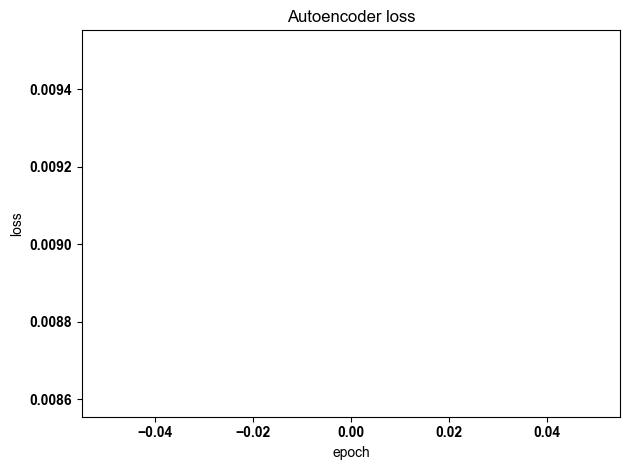

In [12]:
"""
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 ** (epoch / 20)
)

encoder = load_model('encoder.h5')
decoder = load_model('decoder.h5')
model = load_model('ae_model.h5')

model.compile(optimizer = Adam(learning_rate = 1e-8),
              loss = ['binary_crossentropy', 'mse'])
history = model.fit([X_atoms_train, X_bonds_train],
                    [X_smiles_train, y_train],
                    validation_data = ([X_atoms_test, X_bonds_test],
                                       [X_smiles_test, y_test]),
                    epochs = 1,
                    batch_size = 32,
                    verbose = 1,
                    callbacks = [lr_schedule])



plt.semilogx(history.history['lr'],
             history.history['val_Decoder_loss'])

encoder = Model([inp_1, inp_2], [y1_emb, y2_emb, y_out], name = 'Encoder')
decoder = Model(emb_in, [y, y_cv], name = 'Decoder')

print (encoder.summary())
print (decoder.summary())

outputs = decoder(encoder([inp_1, inp_2])[2])
model = Model([inp_1, inp_2], outputs, name = 'ae')

model.compile(optimizer = Adam(learning_rate = 9e-5),
              loss = ['binary_crossentropy', 'mse'])

model.fit([X_atoms_train, X_bonds_train],
                    [X_smiles_train, y_train],
                    validation_data = ([X_atoms_test, X_bonds_test],
                                       [X_smiles_test, y_test]),
                    epochs = 1,
                    batch_size = 32,
                    verbose = 1)
"""
"""
try:
    encoder = load_model('./../data/nns/keep/encoder.h5')
    decoder = load_model('./../data/nns/keep/decoder.h5')
    model = load_model  ('./../data/nns/keep/ae_model.h5')
    model.compile(optimizer = Adam(learning_rate = 9e-6),
            loss = ['binary_crossentropy', 'mse'])
    print (".h5 files were read")
except:
    print ("NO .h5 trained files")
    model.compile(optimizer = Adam(learning_rate = 9e-5),
            loss = ['binary_crossentropy', 'mse'])
    pass
"""

#model.load_weights('./../data/nns/ae_model.h5')
#encoder.load_weights('./../data/nns/encoder.h5')
#decoder.load_weights('./../data/nns/decoder.h5')
#encoder = load_model('./../data/nns/encoder.h5')
#decoder = load_model('./../data/nns/decoder.h5')
#model = load_model('./../data/nns/ae_model.h5')
encoder = load_model('./../data/nns/keep/encoder.h5')
decoder = load_model('./../data/nns/keep/decoder.h5')
model = load_model('./../data/nns/keep/ae_model.h5')
# 0.01 gets the best accuracy
model.compile(optimizer = Adam(learning_rate = 1e-6), 
              loss = ['binary_crossentropy', 'mse'], loss_weights = [1.0, 1.0],)

history = model.fit(X_smiles_train,
                    [X_smiles_train, y_train],
                    validation_data = (X_smiles_test,
                                       [X_smiles_test, y_test]),
                    epochs=1,
                    batch_size=64,
                    verbose=1)

model.save  ('./../data/nns/ae_model.h5')
encoder.save('./../data/nns/encoder.h5')
decoder.save('./../data/nns/decoder.h5')

tf.compat.v1.keras.backend.clear_session()

print(history.history.keys())
# summarize history for loss
plt.close()
plt.plot(history.history['val_loss'])

plt.title('Autoencoder loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.tight_layout()
plt.savefig('aeloss.jpeg', dpi=400)

# get i and i+2 to have (2,9,10,1) shape
# if only i was chosen, the should be (9,10,1)
output = decoder.predict(encoder.predict([X_smiles_train[0:2][:][:][:]])[2])[0][0]
output = argmax (output, axis=1)
output = to_categorical (output, num_classes = 19)
print (SMILES_train[0])
print (output.shape)
print ('output of decoder', output)
print (y_train[0])
print (SMILES_test.shape)
with open ('aeloss.csv', 'w') as f:
    for key in history.history.keys():
        f.write("%s,%s\n"%(key,history.history[key]))

In [13]:
encoder = load_model('./../data/nns/keep/encoder.h5')
decoder = load_model('./../data/nns/keep/decoder.h5')
model = load_model('./../data/nns/keep/ae_model.h5')

In [14]:
tf.compat.v1.keras.backend.clear_session()

0.2728181818181818


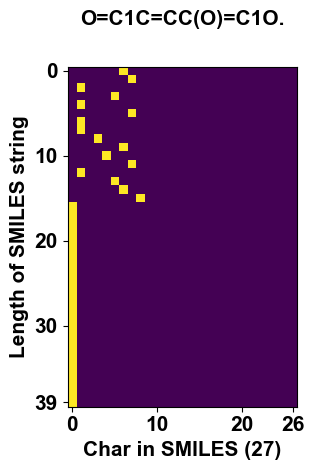

In [15]:

plt.imshow(X_smiles_test[200].reshape([40, 27]), )
plt.title(SMILES_test[200], fontfamily='Arial', fontsize=15, fontweight='bold', pad=30)
plt.xlabel('Char in SMILES (27)', fontfamily='Arial', fontsize=15, fontweight='bold'), 
plt.ylabel('Length of SMILES string', fontfamily='Arial', fontsize=15, fontweight='bold')
plt.xticks((0, 10, 20, 26), size=15)
plt.yticks((0, 10, 20, 30, 39), size=15)
plt.tight_layout()
plt.tight_layout()
plt.savefig('sample_smiles_{}'.format(SMILES_test[200]), dpi=500)
print (y_test0[200])

5 CCCCCCC(N)CO.
10 Nc1nncc2cc[nH]c12.
32 CCNC(=O)CN1CCCCC1C(=O)O.
88 COCc1ccc(-c2ccno2)cn1.
99 COC(=O)c1c(C)cc(C)cc1OC.


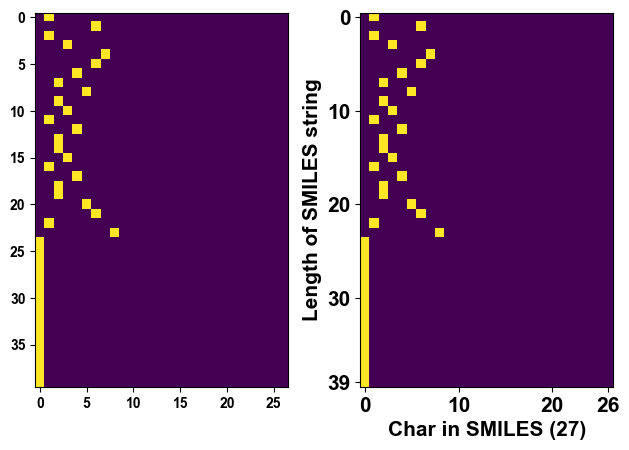

In [16]:
for i in [5, 10, 32, 88, 99]:
    plt.subplot(121)
    plt.imshow(X_smiles_test[i].reshape([40, 27]))
    test_sample_pred = decoder.predict(encoder.predict([X_smiles_test[i:(i+2)]], verbose=0)[2], verbose=0)[0][0]
    plt.subplot(122)
    plt.imshow(test_sample_pred.reshape([40, 27]))
    plt.xlabel('Char in SMILES (27)', fontfamily='Arial', fontsize=15, fontweight='bold'), 
    plt.ylabel('Length of SMILES string', fontfamily='Arial', fontsize=15, fontweight='bold')
    plt.xticks((0, 10, 20, 26), size=15)
    plt.yticks((0, 10, 20, 30, 39), size=15)
    plt.tight_layout()
    plt.savefig("smiles_{}_test.png".format(i), dpi=500)
    print (i, SMILES_test[i])

50 CC1(C)CCC(CO)C23C4CC(CC412)C3(C)C.
100 COCCOc1ccc(C#N)c(F)c1.
320 COc1ccc(N)c2nc(C)c(C)nc12.
880 COc1c2c(cc3c1OCO3)CC(C)O2.
990 N#Cc1ncccc1CNCC1CCOCC1.


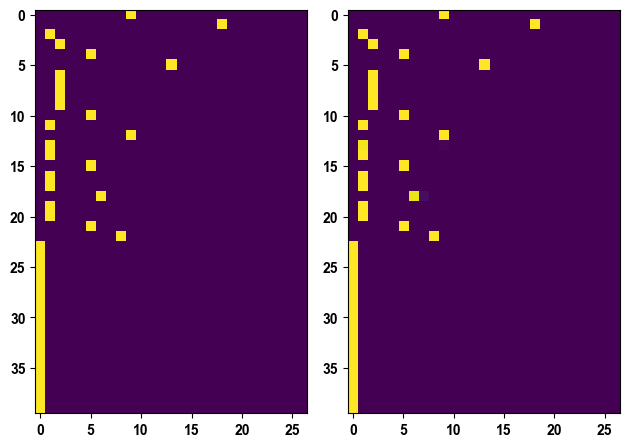

In [17]:
for i in [50, 100, 320, 880, 990]:
    plt.subplot(121)
    plt.imshow(X_smiles_test[i].reshape([40, 27]))
    test_sample_pred = decoder.predict(encoder.predict([X_smiles_test[i:(i+2)]], verbose=0)[2], verbose=0)[0][0]
    plt.subplot(122)
    plt.imshow(test_sample_pred.reshape([40, 27]))
    plt.tight_layout()
    plt.savefig("smiles_{}_test.png".format(i), dpi=500)
    print (i, SMILES_test[i])

In [18]:
X_smiles_test.shape

(24819, 40, 27, 1)

In [19]:
# Evaluation: test data
# 0.8113100848256362 valid and true
# 0.8619792648444863  valid
encoder_latent_test = encoder.predict(X_smiles_test, verbose=0)[2]
decoder_smiles_test = decoder.predict(encoder_latent_test, verbose=0)[0]

dec_SMILES_test = []
for softmax_smiles in decoder_smiles_test:
    argmax_smiles = np.argmax(softmax_smiles, axis = 1).reshape([-1])
    #print (argmax_smiles)
    smiles = to_categorical(argmax_smiles, num_classes=27)
    SHAPE = [1] + list(smiles.shape) + [1]
    smiles = smiles.reshape(SHAPE)
    c_smiles = ''
    for s in argmax_smiles:
        c_smiles += tokenizer[s]
        c_smiles = c_smiles.rstrip()
    dec_SMILES_test.append(c_smiles)
    
test_true_conv = sum (SMILES_test == dec_SMILES_test)/len(SMILES_test)
print (test_true_conv)

idxs_test = []
valid_test = 0

for count, smile in enumerate(dec_SMILES_test):
    m = Chem.MolFromSmiles(smile[:-1], sanitize=True)
    if m is not None:
        valid_test += 1
        idxs_test.append(count)

test_valid_conv = valid_test/len(SMILES_test)
print (test_valid_conv)

0.8670776421290141
0.9043071840122486


In [20]:
conv_test = SMILES_test == np.array (dec_SMILES_test)

In [21]:
count = 0
for i,j in zip(SMILES_test, dec_SMILES_test):
    if i==j:
        count +=

SyntaxError: invalid syntax (3843249358.py, line 4)

In [ ]:
count/len(SMILES_test)

0.8670776421290141

In [ ]:
# Evaluation: train data
# 0.8113100848256362 valid and true
# 0.8619792648444863  valid
encoder_latent_train = encoder.predict(X_smiles_train, verbose=0)[2]
decoder_smiles_train = decoder.predict(encoder_latent_train, verbose=0)[0]

dec_SMILES_train = []
for softmax_smiles in decoder_smiles_train:
    argmax_smiles = np.argmax(softmax_smiles, axis = 1).reshape([-1])
    #print (argmax_smiles)
    smiles = to_categorical(argmax_smiles, num_classes=27)
    SHAPE = [1] + list(smiles.shape) + [1]
    smiles = smiles.reshape(SHAPE)
    c_smiles = ''
    for s in argmax_smiles:
        c_smiles += tokenizer[s]
        c_smiles = c_smiles.rstrip()
    dec_SMILES_train.append(c_smiles)
    
train_true_conv = sum (SMILES_train == dec_SMILES_train)/len(SMILES_train)
print (train_true_conv)

idxs_train = []
valid_train = 0

for count, smile in enumerate(dec_SMILES_train):
    m = Chem.MolFromSmiles(smile[:-1], sanitize=True)
    if m is not None:
        valid_train += 1
        idxs_train.append(count)

train_valid_conv = valid_train/len(SMILES_train)
print (train_valid_conv)

0.9959943827108133
0.9976720294813433


In [ ]:
# all data evaluation
# 77.574 valid 
# 71.1124 valid and accurate
valid_conv = (4*train_valid_conv + test_valid_conv)/5
print ('Valid conversion: ', valid_conv)

true_conv = (4*train_true_conv + test_true_conv)/5
print ('Valid and True conversion: ', true_conv)

Valid conversion:  0.9789829437027263
Valid and True conversion:  0.9702110345944535


In [ ]:
def diff_letters(a,b):
    return sum ( a[i] != b[i] for i in range(len(a)) )
# Evaluation: test data
# 98.01629884592023 categorical accuracy
encoder_latent_test = encoder.predict(X_smiles_test, verbose=0)[2]
decoder_smiles_test = decoder.predict(encoder_latent_test, verbose=0)[0]

dec_SMILES_test = []
for softmax_smiles in decoder_smiles_test:
    argmax_smiles = np.argmax(softmax_smiles, axis = 1).reshape([-1])
    #print (argmax_smiles)
    smiles = to_categorical(argmax_smiles, num_classes=27)
    SHAPE = [1] + list(smiles.shape) + [1]
    smiles = smiles.reshape(SHAPE)
    c_smiles = ''
    for s in argmax_smiles:
        c_smiles += tokenizer[s]
        c_smiles = c_smiles.rstrip()
    dec_SMILES_test.append(c_smiles)

wrong_char = 0
total_char = 0
for i, j in zip(dec_SMILES_test, SMILES_test):
    try:
        wrong_char = wrong_char + diff_letters(i, j)
    except:
        print(i, j)
    total_char = total_char + len(i) 
print (wrong_char)
print ('% of correct char conv train: ', 100-wrong_char/total_char*100)

CC1(C)CCC(CO)C23C(CC(CCC(3)C)CC)C.C. CC1(C)CCC(CO)C23C4CC(CC412)C3(C)C.
O=C1C=C[C](O)c2cc3c(cc23)[C]2CCCC3O. O=C1C=C[C](O)c2cc3c(cc21)[CH]C=CC3.
CN=C1[C](C#N)[N+]([O-])c2ccccc2CNCO. CN=C1[C](C#N)[N+]([O-])c2ccccc2N1O.
O=[N+]([O-])c1cccc(-c2cc(O)ccc2O)c12. O=[N+]([O-])c1cccc(-c2cc(O)ccc2O)c1.
NC1=C2[CH](=C[=C2N=C([N]c2ccccc2cc11. NC1=C2[CH]C=CN=C2N=C([N]c2ccccc2)N1.
O=[N+]([O-])C1OCc2cc3cccc32C1=O)CC2.. O=[N+]([O-])C1=Cc2cc3c(cc2OC1)OCCO3.
Cc1nc2cc([N+](=O)[O-])c(N)cc221=O. Cc1nc2cc([N+](=O)[O-])c(N)cc2n1C.
[CH]1[CH]([CH]c2c(cccccccnC2)[C]2.. [CH]1[CH]S[CH]c2c(cc3ccccn23)[N]1.
CC(C)COC(=O)C=Cc1ccc([N+](=O)[O-])c11. CC(C)COC(=O)C=Cc1ccc([N+](=O)[O-])o1.
Cc1nc(nH]c1[CH][C]=C(O)=N22occc2cc12=O. Cc1nc[nH]c1[CH][C]1C(O)=Nc2ccc(N)cc21.
[CH]]COCC]CC2C[CH1c1ccc(C(C)CCC)C2. [CH2]C#CC#CC#C[CH]c1ccc(C(C)C)cc1.
N#CC(=Cc1ccc(O)cc1)C(O)=C(C#N)C1N.. N#CC(=Cc1ccc(O)cc1)C(N)=C(C#N)C#N.
CCn1c(=O)n(C)c2c(=O)n(C)c(=O)n2C2)n.2. CCn1c(=O)n(C)c2c(=O)n(C)c(=O)n(C)c21.
O=C1[CH][C][CH]c3cc3cccc232[C=C)CCCC)21. O

In [ ]:
# Evaluation: train data
#  99.98139237365801 categorical accuracy
encoder_latent_train = encoder.predict(X_smiles_train, verbose=0)[2]
decoder_smiles_train = decoder.predict(encoder_latent_train, verbose=0)[0]

dec_SMILES_train = []
for softmax_smiles in decoder_smiles_train:
    argmax_smiles = np.argmax(softmax_smiles, axis = 1).reshape([-1])
    #print (argmax_smiles)
    smiles = to_categorical(argmax_smiles, num_classes=27)
    SHAPE = [1] + list(smiles.shape) + [1]
    smiles = smiles.reshape(SHAPE)
    c_smiles = ''
    for s in argmax_smiles:
        c_smiles += tokenizer[s]
        c_smiles = c_smiles.rstrip()
    dec_SMILES_train.append(c_smiles)

wrong_char = 0
total_char = 0
for i, j in zip(dec_SMILES_train, SMILES_train):
    try:
        wrong_char = wrong_char + diff_letters(i, j)
    except:
        print(i, j)
    total_char = total_char + len(i) 
print ('% of correct char conv train: ', 100-wrong_char/total_char*100)

C[C](O)[N][N][CH]c1ccc([N+](=O)[O-])cc1. C[C](O)[N][N][CH]c1ccc([N+](=O)[O-])s1.
C[C](O)[N][N][CH]c1ccc([N+](=O)[O-])cc1. C[C](O)[N][N][CH]c1ccc([N+](=O)[O-])o1.
% of correct char conv train:  99.98139237365801
